# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [62]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [63]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [64]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [65]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

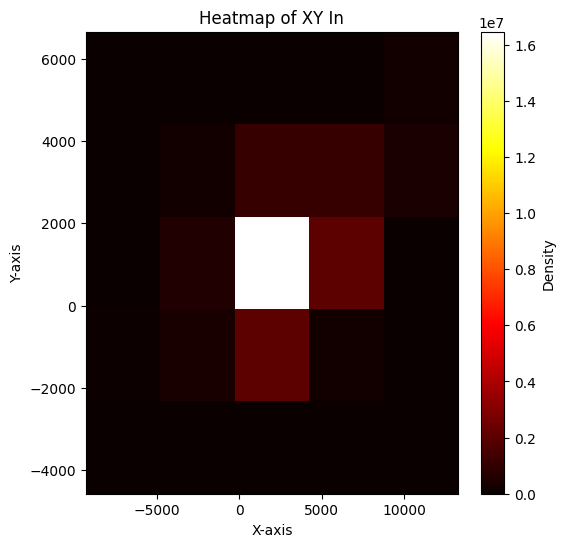

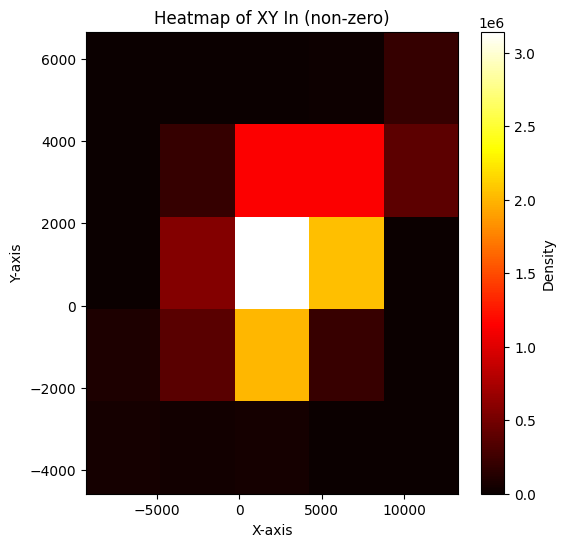

In [66]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

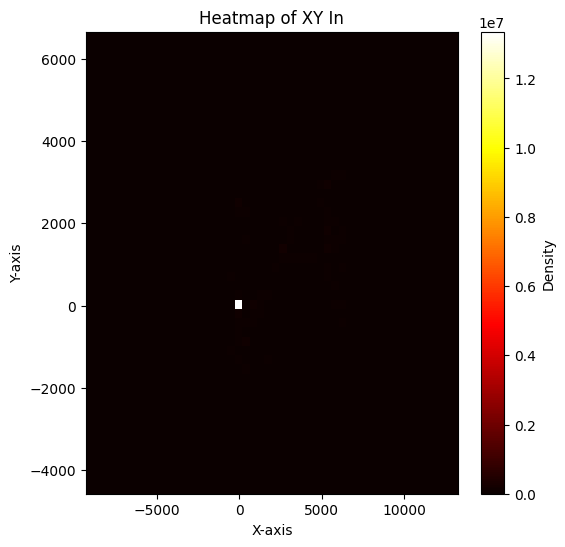

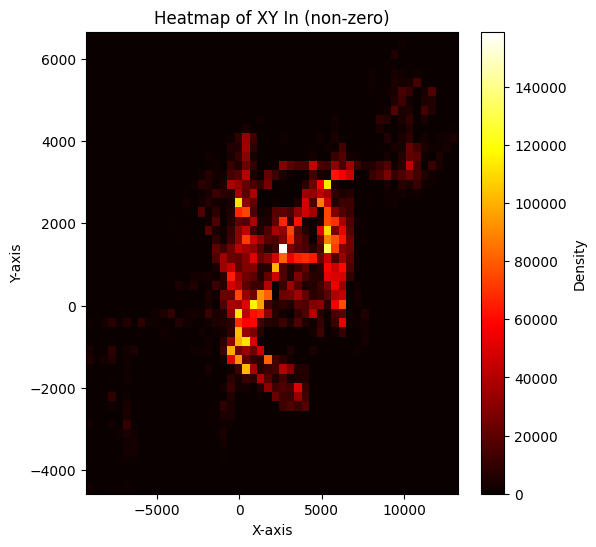

In [67]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [68]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [69]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [70]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [71]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [72]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Trying Transformer Model

In [73]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=6, model_dim=128, num_heads=4, num_layers=2, output_dim=60*2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent index 0, shape: (batch, 50, 6)
        x = self.input_proj(x)  # (batch, 50, model_dim)
        x = self.transformer_encoder(x)  # (batch, 50, model_dim)
        out = self.fc(x[:, -1, :])  # Use last time step's output
        return out.view(-1, 60, 2)

In [74]:
class AdvancedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoder for future trajectory
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x + self.pos_encoding[:, :self.seq_len, :]  # Add positional encoding
        x = self.encoder(x)  # (batch, seq, model_dim)
        x = x[:, -1, :]  # Use last time step's output (batch, model_dim)
        out = self.decoder(x)  # (batch, future_len*2)
        return out.view(-1, self.future_len, 2)

In [75]:
class BeefedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Temporal convolution for local feature extraction
        self.temporal_conv = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=1, groups=input_dim)
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*6,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Deeper MLP decoder with residual connection
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim*2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        # Temporal convolution
        x = x.transpose(1, 2)  # (batch, features, seq)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)  # (batch, seq, features)
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :self.seq_len, :]
        x = self.encoder(x)
        x = x[:, -1, :]  # Last time step
        out = self.decoder(x)
        return out.view(-1, self.future_len, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [76]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = TransformerModel().to(device)
# model = AdvancedTransformerModel().to(device)
# model = AdvancedTransformerModel(
#     input_dim=6,
#     model_dim=512,      # 2x wider
#     num_heads=16,       # 2x more heads
#     num_layers=12,      # 2x deeper
#     seq_len=50,
#     future_len=60,
#     dropout=0.10        # Slightly higher dropout for regularization
# ).to(device)
# model = BeefedTransformerModel(
#     input_dim=6,
#     model_dim=1152,
#     num_heads=36,
#     num_layers=20,
#     seq_len=50,
#     future_len=60,
#     dropout=0.15
# ).to(device)
model = TransformerModel(dropout=0).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 20
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [77]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   1%|          | 1/100 [00:03<05:56,  3.60s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.2678 | val normalized MSE   0.3592, | val MAE   2.4648 | val MSE  17.5996


Epoch:   2%|▏         | 2/100 [00:07<05:42,  3.50s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3533 | val normalized MSE   0.3206, | val MAE   2.3590 | val MSE  15.7114


Epoch:   3%|▎         | 3/100 [00:10<05:47,  3.58s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3100 | val normalized MSE   0.2825, | val MAE   1.9760 | val MSE  13.8417


Epoch:   4%|▍         | 4/100 [00:14<05:49,  3.64s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3042 | val normalized MSE   0.2918, | val MAE   2.0785 | val MSE  14.2991


Epoch:   5%|▌         | 5/100 [00:18<05:51,  3.70s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2969 | val normalized MSE   0.2539, | val MAE   1.9632 | val MSE  12.4406


Epoch:   6%|▌         | 6/100 [00:22<05:50,  3.73s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2801 | val normalized MSE   0.3738, | val MAE   2.3367 | val MSE  18.3140


Epoch:   7%|▋         | 7/100 [00:25<05:45,  3.71s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2871 | val normalized MSE   0.2946, | val MAE   2.3093 | val MSE  14.4369


Epoch:   8%|▊         | 8/100 [00:29<05:43,  3.74s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2842 | val normalized MSE   0.2670, | val MAE   2.0059 | val MSE  13.0809


Epoch:   9%|▉         | 9/100 [00:33<05:48,  3.82s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2596 | val normalized MSE   0.2635, | val MAE   1.9909 | val MSE  12.9108


Epoch:  10%|█         | 10/100 [00:37<05:43,  3.81s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2790 | val normalized MSE   0.2626, | val MAE   1.8342 | val MSE  12.8660


Epoch:  11%|█         | 11/100 [00:40<05:32,  3.74s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2620 | val normalized MSE   0.2370, | val MAE   1.7946 | val MSE  11.6145


Epoch:  12%|█▏        | 12/100 [00:44<05:22,  3.67s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2541 | val normalized MSE   0.2517, | val MAE   1.8600 | val MSE  12.3346


Epoch:  13%|█▎        | 13/100 [00:48<05:19,  3.67s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2642 | val normalized MSE   0.2613, | val MAE   1.9809 | val MSE  12.8023


Epoch:  14%|█▍        | 14/100 [00:51<05:18,  3.70s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2492 | val normalized MSE   0.2475, | val MAE   1.8343 | val MSE  12.1276


Epoch:  15%|█▌        | 15/100 [00:55<05:15,  3.72s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2464 | val normalized MSE   0.2415, | val MAE   1.8885 | val MSE  11.8359


Epoch:  16%|█▌        | 16/100 [00:59<05:09,  3.68s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2401 | val normalized MSE   0.2676, | val MAE   1.9696 | val MSE  13.1147


Epoch:  17%|█▋        | 17/100 [01:02<05:03,  3.66s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2525 | val normalized MSE   0.2327, | val MAE   1.7846 | val MSE  11.4021


Epoch:  18%|█▊        | 18/100 [01:06<05:07,  3.76s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2424 | val normalized MSE   0.2135, | val MAE   1.6353 | val MSE  10.4618


Epoch:  19%|█▉        | 19/100 [01:10<05:03,  3.74s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2352 | val normalized MSE   0.2677, | val MAE   2.0208 | val MSE  13.1194


Epoch:  20%|██        | 20/100 [01:14<05:00,  3.76s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2433 | val normalized MSE   0.2185, | val MAE   1.6824 | val MSE  10.7041


Epoch:  21%|██        | 21/100 [01:18<04:56,  3.75s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2015 | val normalized MSE   0.1899, | val MAE   1.4805 | val MSE   9.3027


Epoch:  22%|██▏       | 22/100 [01:21<04:57,  3.82s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.1954 | val normalized MSE   0.1983, | val MAE   1.5480 | val MSE   9.7153


Epoch:  23%|██▎       | 23/100 [01:25<04:53,  3.81s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.1944 | val normalized MSE   0.2048, | val MAE   1.5842 | val MSE  10.0358


Epoch:  24%|██▍       | 24/100 [01:29<04:44,  3.74s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.1925 | val normalized MSE   0.1866, | val MAE   1.4346 | val MSE   9.1426


Epoch:  25%|██▌       | 25/100 [01:33<04:40,  3.75s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1940 | val normalized MSE   0.1903, | val MAE   1.5152 | val MSE   9.3268


Epoch:  26%|██▌       | 26/100 [01:36<04:33,  3.69s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1936 | val normalized MSE   0.1837, | val MAE   1.3711 | val MSE   9.0009


Epoch:  27%|██▋       | 27/100 [01:40<04:28,  3.67s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1922 | val normalized MSE   0.1865, | val MAE   1.4442 | val MSE   9.1390


Epoch:  28%|██▊       | 28/100 [01:44<04:25,  3.69s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1899 | val normalized MSE   0.1866, | val MAE   1.4271 | val MSE   9.1428


Epoch:  29%|██▉       | 29/100 [01:47<04:20,  3.67s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1917 | val normalized MSE   0.1866, | val MAE   1.4685 | val MSE   9.1444


Epoch:  30%|███       | 30/100 [01:51<04:17,  3.67s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1908 | val normalized MSE   0.1978, | val MAE   1.5461 | val MSE   9.6911


Epoch:  31%|███       | 31/100 [01:54<04:10,  3.63s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1907 | val normalized MSE   0.1939, | val MAE   1.6263 | val MSE   9.5000


Epoch:  32%|███▏      | 32/100 [01:58<04:07,  3.64s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1888 | val normalized MSE   0.1859, | val MAE   1.4752 | val MSE   9.1088


Epoch:  33%|███▎      | 33/100 [02:02<04:06,  3.68s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1909 | val normalized MSE   0.1934, | val MAE   1.6011 | val MSE   9.4767


Epoch:  34%|███▍      | 34/100 [02:05<04:01,  3.65s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1897 | val normalized MSE   0.2001, | val MAE   1.5540 | val MSE   9.8072


Epoch:  35%|███▌      | 35/100 [02:09<03:57,  3.65s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1872 | val normalized MSE   0.1906, | val MAE   1.5790 | val MSE   9.3371


Epoch:  36%|███▌      | 36/100 [02:13<03:52,  3.63s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1887 | val normalized MSE   0.1858, | val MAE   1.5503 | val MSE   9.1062


Epoch:  37%|███▋      | 37/100 [02:16<03:47,  3.61s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1874 | val normalized MSE   0.1907, | val MAE   1.5214 | val MSE   9.3428


Epoch:  38%|███▊      | 38/100 [02:20<03:46,  3.66s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1880 | val normalized MSE   0.1849, | val MAE   1.5087 | val MSE   9.0606


Epoch:  39%|███▉      | 39/100 [02:24<03:43,  3.66s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1893 | val normalized MSE   0.1917, | val MAE   1.4756 | val MSE   9.3918


Epoch:  40%|████      | 40/100 [02:27<03:41,  3.69s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1877 | val normalized MSE   0.1850, | val MAE   1.4635 | val MSE   9.0658


Epoch:  41%|████      | 41/100 [02:31<03:36,  3.67s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1777 | val normalized MSE   0.1787, | val MAE   1.3974 | val MSE   8.7581


Epoch:  42%|████▏     | 42/100 [02:35<03:32,  3.66s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1753 | val normalized MSE   0.1723, | val MAE   1.3460 | val MSE   8.4441


Epoch:  43%|████▎     | 43/100 [02:38<03:29,  3.68s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1743 | val normalized MSE   0.1742, | val MAE   1.3642 | val MSE   8.5374


Epoch:  44%|████▍     | 44/100 [02:42<03:24,  3.66s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1743 | val normalized MSE   0.1772, | val MAE   1.3790 | val MSE   8.6809


Epoch:  45%|████▌     | 45/100 [02:46<03:21,  3.66s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1739 | val normalized MSE   0.1741, | val MAE   1.3798 | val MSE   8.5316


Epoch:  46%|████▌     | 46/100 [02:49<03:16,  3.64s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1745 | val normalized MSE   0.1729, | val MAE   1.3420 | val MSE   8.4705


Epoch:  47%|████▋     | 47/100 [02:53<03:12,  3.63s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1743 | val normalized MSE   0.1763, | val MAE   1.3832 | val MSE   8.6397


Epoch:  48%|████▊     | 48/100 [02:57<03:11,  3.68s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1738 | val normalized MSE   0.1745, | val MAE   1.3522 | val MSE   8.5488


Epoch:  49%|████▉     | 49/100 [03:00<03:08,  3.69s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1734 | val normalized MSE   0.1719, | val MAE   1.3583 | val MSE   8.4228


Epoch:  50%|█████     | 50/100 [03:04<03:04,  3.69s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1733 | val normalized MSE   0.1722, | val MAE   1.3707 | val MSE   8.4385


Epoch:  51%|█████     | 51/100 [03:08<03:00,  3.68s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1730 | val normalized MSE   0.1711, | val MAE   1.3414 | val MSE   8.3852


Epoch:  52%|█████▏    | 52/100 [03:11<02:55,  3.66s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1727 | val normalized MSE   0.1751, | val MAE   1.3703 | val MSE   8.5803


Epoch:  53%|█████▎    | 53/100 [03:15<02:54,  3.72s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1731 | val normalized MSE   0.1771, | val MAE   1.4096 | val MSE   8.6802


Epoch:  54%|█████▍    | 54/100 [03:19<02:49,  3.68s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1730 | val normalized MSE   0.1715, | val MAE   1.3705 | val MSE   8.4049


Epoch:  55%|█████▌    | 55/100 [03:22<02:45,  3.67s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1735 | val normalized MSE   0.1741, | val MAE   1.3958 | val MSE   8.5292


Epoch:  56%|█████▌    | 56/100 [03:26<02:42,  3.69s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1728 | val normalized MSE   0.1750, | val MAE   1.4131 | val MSE   8.5755


Epoch:  57%|█████▋    | 57/100 [03:30<02:38,  3.69s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1741 | val normalized MSE   0.1741, | val MAE   1.3584 | val MSE   8.5316


Epoch:  58%|█████▊    | 58/100 [03:34<02:38,  3.76s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1727 | val normalized MSE   0.1702, | val MAE   1.3593 | val MSE   8.3409


Epoch:  59%|█████▉    | 59/100 [03:38<02:34,  3.76s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1718 | val normalized MSE   0.1713, | val MAE   1.3338 | val MSE   8.3931


Epoch:  60%|██████    | 60/100 [03:41<02:30,  3.77s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1719 | val normalized MSE   0.1720, | val MAE   1.3662 | val MSE   8.4300


Epoch:  61%|██████    | 61/100 [03:45<02:25,  3.73s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1690 | val normalized MSE   0.1689, | val MAE   1.3387 | val MSE   8.2740


Epoch:  62%|██████▏   | 62/100 [03:48<02:19,  3.68s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1687 | val normalized MSE   0.1702, | val MAE   1.3247 | val MSE   8.3376


Epoch:  63%|██████▎   | 63/100 [03:52<02:16,  3.68s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1687 | val normalized MSE   0.1701, | val MAE   1.3271 | val MSE   8.3355


Epoch:  64%|██████▍   | 64/100 [03:56<02:12,  3.69s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1686 | val normalized MSE   0.1694, | val MAE   1.3189 | val MSE   8.3012


Epoch:  65%|██████▌   | 65/100 [04:00<02:10,  3.73s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1685 | val normalized MSE   0.1697, | val MAE   1.3256 | val MSE   8.3149


Epoch:  66%|██████▌   | 66/100 [04:03<02:07,  3.74s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1687 | val normalized MSE   0.1690, | val MAE   1.3215 | val MSE   8.2794


Epoch:  67%|██████▋   | 67/100 [04:07<02:02,  3.72s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1681 | val normalized MSE   0.1693, | val MAE   1.3258 | val MSE   8.2935


Epoch:  68%|██████▊   | 68/100 [04:11<02:00,  3.76s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1680 | val normalized MSE   0.1698, | val MAE   1.3275 | val MSE   8.3208


Epoch:  69%|██████▉   | 69/100 [04:15<01:56,  3.75s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1674 | val normalized MSE   0.1696, | val MAE   1.3395 | val MSE   8.3113


Epoch:  70%|███████   | 70/100 [04:19<01:52,  3.76s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1679 | val normalized MSE   0.1692, | val MAE   1.3139 | val MSE   8.2904


Epoch:  71%|███████   | 71/100 [04:22<01:47,  3.72s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1680 | val normalized MSE   0.1690, | val MAE   1.3356 | val MSE   8.2813


Epoch:  72%|███████▏  | 72/100 [04:26<01:43,  3.68s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1675 | val normalized MSE   0.1703, | val MAE   1.3450 | val MSE   8.3425


Epoch:  73%|███████▎  | 73/100 [04:29<01:39,  3.69s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1681 | val normalized MSE   0.1691, | val MAE   1.3432 | val MSE   8.2856


Epoch:  74%|███████▍  | 74/100 [04:33<01:35,  3.66s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1684 | val normalized MSE   0.1683, | val MAE   1.3181 | val MSE   8.2459


Epoch:  75%|███████▌  | 75/100 [04:37<01:32,  3.68s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1681 | val normalized MSE   0.1694, | val MAE   1.3225 | val MSE   8.3011


Epoch:  76%|███████▌  | 76/100 [04:40<01:28,  3.68s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1686 | val normalized MSE   0.1692, | val MAE   1.3309 | val MSE   8.2902


Epoch:  77%|███████▋  | 77/100 [04:44<01:24,  3.69s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1682 | val normalized MSE   0.1679, | val MAE   1.3188 | val MSE   8.2272


Epoch:  78%|███████▊  | 78/100 [04:48<01:22,  3.76s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1682 | val normalized MSE   0.1685, | val MAE   1.3308 | val MSE   8.2573


Epoch:  79%|███████▉  | 79/100 [04:52<01:18,  3.74s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1678 | val normalized MSE   0.1698, | val MAE   1.3331 | val MSE   8.3199


Epoch:  80%|████████  | 80/100 [04:55<01:13,  3.68s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1676 | val normalized MSE   0.1689, | val MAE   1.3359 | val MSE   8.2760


Epoch:  81%|████████  | 81/100 [04:59<01:09,  3.64s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1672 | val normalized MSE   0.1677, | val MAE   1.3168 | val MSE   8.2154


Epoch:  82%|████████▏ | 82/100 [05:02<01:05,  3.61s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1670 | val normalized MSE   0.1679, | val MAE   1.3189 | val MSE   8.2275


Epoch:  83%|████████▎ | 83/100 [05:06<01:01,  3.61s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1669 | val normalized MSE   0.1678, | val MAE   1.3169 | val MSE   8.2229


Epoch:  84%|████████▍ | 84/100 [05:10<00:57,  3.59s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1666 | val normalized MSE   0.1676, | val MAE   1.3121 | val MSE   8.2123


Epoch:  85%|████████▌ | 85/100 [05:13<00:53,  3.57s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1663 | val normalized MSE   0.1673, | val MAE   1.3117 | val MSE   8.2000


Epoch:  86%|████████▌ | 86/100 [05:17<00:49,  3.55s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1666 | val normalized MSE   0.1678, | val MAE   1.3132 | val MSE   8.2237


Epoch:  87%|████████▋ | 87/100 [05:20<00:46,  3.55s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1668 | val normalized MSE   0.1679, | val MAE   1.3141 | val MSE   8.2250


Epoch:  88%|████████▊ | 88/100 [05:24<00:43,  3.60s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1669 | val normalized MSE   0.1674, | val MAE   1.3082 | val MSE   8.2005


Epoch:  89%|████████▉ | 89/100 [05:27<00:39,  3.60s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1665 | val normalized MSE   0.1675, | val MAE   1.3152 | val MSE   8.2070


Epoch:  90%|█████████ | 90/100 [05:31<00:35,  3.58s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1668 | val normalized MSE   0.1672, | val MAE   1.3134 | val MSE   8.1940


Epoch:  91%|█████████ | 91/100 [05:34<00:31,  3.55s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1667 | val normalized MSE   0.1676, | val MAE   1.3154 | val MSE   8.2109


Epoch:  92%|█████████▏| 92/100 [05:38<00:28,  3.55s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1666 | val normalized MSE   0.1680, | val MAE   1.3179 | val MSE   8.2323


Epoch:  93%|█████████▎| 93/100 [05:42<00:25,  3.59s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1668 | val normalized MSE   0.1679, | val MAE   1.3195 | val MSE   8.2251


Epoch:  94%|█████████▍| 94/100 [05:45<00:21,  3.59s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1666 | val normalized MSE   0.1676, | val MAE   1.3147 | val MSE   8.2105


Epoch:  95%|█████████▌| 95/100 [05:49<00:17,  3.57s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1666 | val normalized MSE   0.1675, | val MAE   1.3140 | val MSE   8.2082


Epoch:  96%|█████████▌| 96/100 [05:52<00:14,  3.55s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1666 | val normalized MSE   0.1678, | val MAE   1.3162 | val MSE   8.2202


Epoch:  97%|█████████▋| 97/100 [05:56<00:10,  3.56s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1666 | val normalized MSE   0.1676, | val MAE   1.3172 | val MSE   8.2109


Epoch:  98%|█████████▊| 98/100 [06:00<00:07,  3.61s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1663 | val normalized MSE   0.1677, | val MAE   1.3145 | val MSE   8.2164


Epoch:  99%|█████████▉| 99/100 [06:03<00:03,  3.60s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1664 | val normalized MSE   0.1678, | val MAE   1.3152 | val MSE   8.2218


Epoch: 100%|██████████| 100/100 [06:07<00:00,  3.67s/epoch]

Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1670 | val normalized MSE   0.1679, | val MAE   1.3183 | val MSE   8.2247


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [78]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

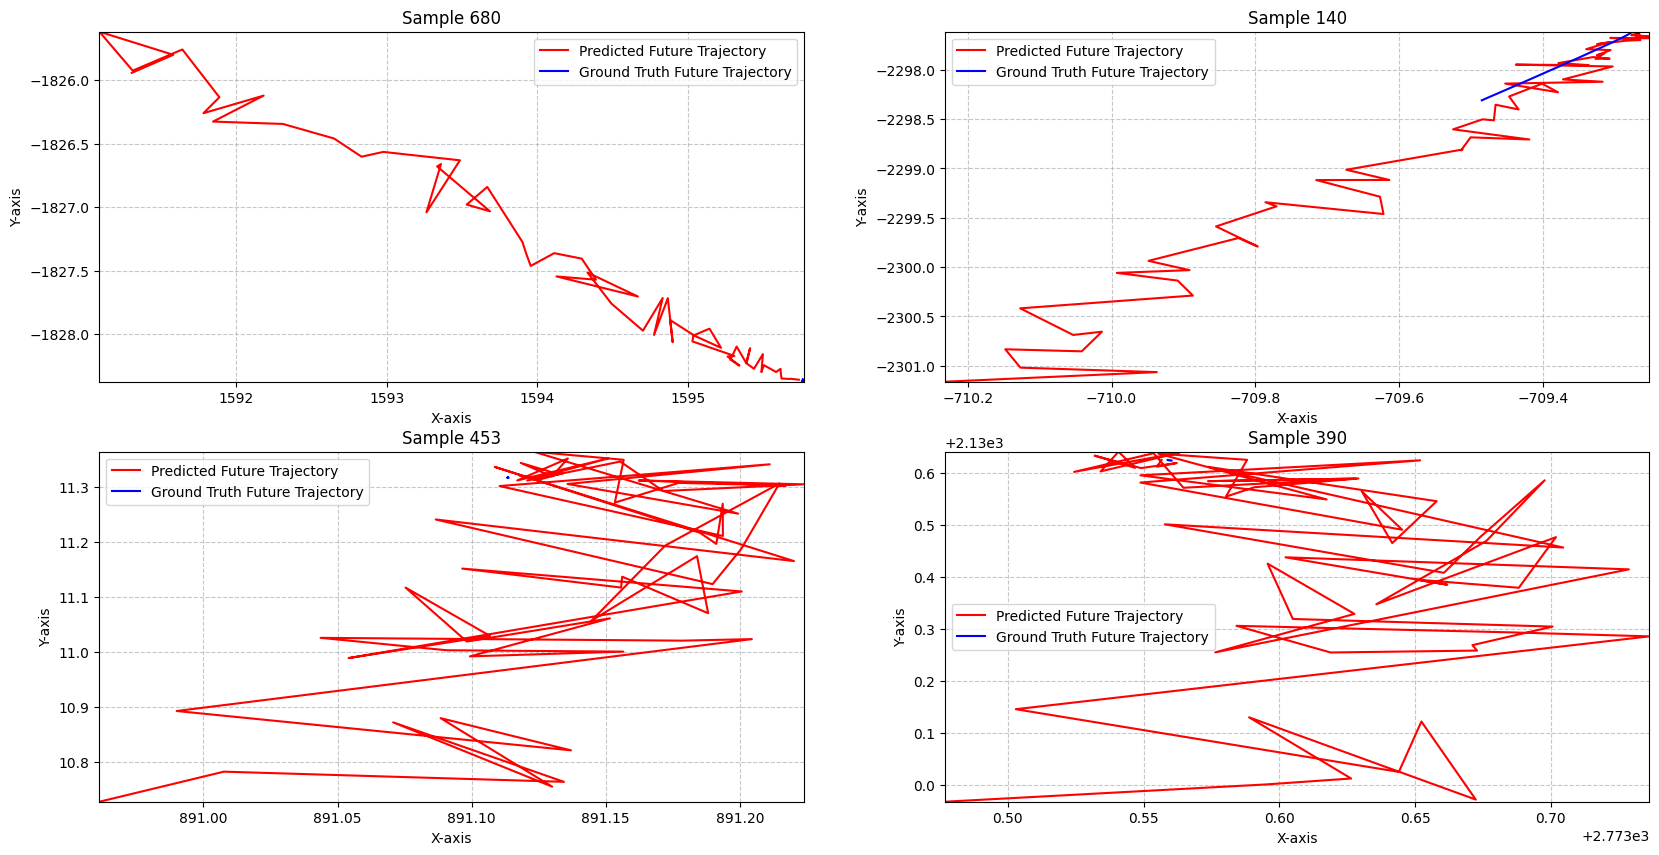

In [79]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [80]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = AdvancedTransformerModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = TransformerModel(dropout=0).to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B